In [1]:
from typing import Callable, Tuple
from finite_distributions.FiniteDistribution import FiniteDistribution
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sinkhorn.SinkhornRunner as SinkhornRunner
import sinkhorn.SinkhornKernels as skern
import visualizer.joint_distribution_visualizer as jdv
import pandas as pd

In [2]:
def gaussian_prob(mu: float, sigma: float, x: float):
    return np.exp(-(x - mu)**2 / (2 * sigma * sigma))

In [3]:
mu_1 = -0.0
sigma_1 = 1.0

mu_2 = 0.0
sigma_2 = np.sqrt(2)

In [4]:
xs = [round(x, 5) for x in np.linspace(-5, 5, 50)]

In [5]:
s1 = np.sum([gaussian_prob(mu_1, sigma_1, x) for x in xs])
s2 = np.sum([gaussian_prob(mu_2, sigma_2, x) for x in xs])

dist_1 = FiniteDistribution({x: gaussian_prob(mu_1, sigma_1, x) / s1 for x in xs})
dist_2 = FiniteDistribution({x: gaussian_prob(mu_2, sigma_2, x) / s2 for x in xs})

In [6]:
c = lambda x, y: (x - y)**2

In [7]:
def unregularized_transport_map(x: float) -> float:
    return mu_2 + (x - mu_1) * (sigma_2/sigma_1)

In [8]:
# p-norm
p = 2.
sinkhorn_runner = skern.get_quadratically_regularized_runner(c, use_parallelization=False)
# entropic
sinkhorn_runner_entropic = skern.get_entropically_regularized_runner(c)


epsilons = np.power(10.0, np.linspace(-2, 1.0, 50))
delta = 0.025

distribution_outputs_quadratic = {}
for epsilon in reversed(epsilons):
    print(f"Running Quadratic, epsilon = {epsilon}")
    pi_p, f_p, g_p, iterations, outer_iterations = sinkhorn_runner.run_sinkhorn(dist_1, dist_2, epsilon, delta)
    distribution_outputs_quadratic[epsilon] = (pi_p, f_p, g_p, iterations, outer_iterations)
    print(f"Done with Quadratic, epsilon = {epsilon}. Inner iterations: {iterations}. Outer iterations: {outer_iterations}")

print("Done with quadratic.")

distribution_outputs_entropic = {}
for epsilon in reversed(epsilons):
    print(f"Running Entropic, epsilon = {epsilon}")
    _, _, _, _, iterations_outer_previous = distribution_outputs_quadratic[epsilon]
    pi_p, f_p, g_p, iterations, outer_iterations = sinkhorn_runner_entropic.run_sinkhorn(dist_1, dist_2, epsilon, delta)
    distribution_outputs_entropic[epsilon] = (pi_p, f_p, g_p, iterations, outer_iterations)
    print(f"Done with Entropic, epsilon = {epsilon}. Inner iterations: {iterations}. Outer iterations: {outer_iterations}")

print("Done with entropic.")

Running Quadratic, epsilon = 10.0
Done with Quadratic, epsilon = 10.0. Inner iterations: 3372. Outer iterations: 1
Running Quadratic, epsilon = 8.68511373751352
Done with Quadratic, epsilon = 8.68511373751352. Inner iterations: 3252. Outer iterations: 1
Running Quadratic, epsilon = 7.543120063354615
Done with Quadratic, epsilon = 7.543120063354615. Inner iterations: 3132. Outer iterations: 1
Running Quadratic, epsilon = 6.551285568595509
Done with Quadratic, epsilon = 6.551285568595509. Inner iterations: 3018. Outer iterations: 1
Running Quadratic, epsilon = 5.689866029018293
Done with Quadratic, epsilon = 5.689866029018293. Inner iterations: 2914. Outer iterations: 1
Running Quadratic, epsilon = 4.941713361323833
Done with Quadratic, epsilon = 4.941713361323833. Inner iterations: 2802. Outer iterations: 1
Running Quadratic, epsilon = 4.291934260128778
Done with Quadratic, epsilon = 4.291934260128778. Inner iterations: 2712. Outer iterations: 1
Running Quadratic, epsilon = 3.7275937203

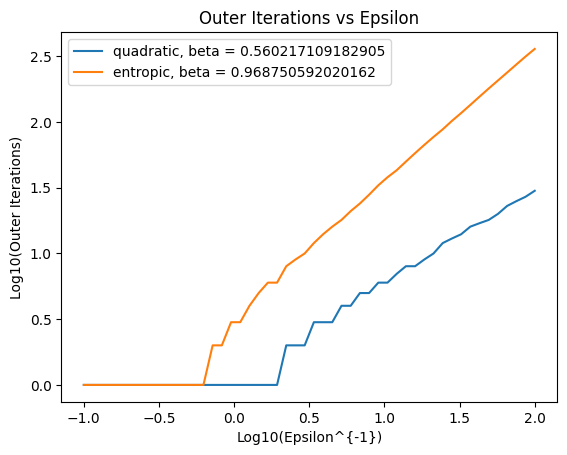

In [9]:
plt.figure()
xs = -np.log10(epsilons)
ys_q = np.log10(np.array([distribution_outputs_quadratic[epsilon][4] for epsilon in epsilons]))
ys_e = np.log10(np.array([distribution_outputs_entropic[epsilon][4] for epsilon in epsilons]))
var_x = np.mean(xs*xs) - np.mean(xs)**2
cov_q = np.mean(ys_q * xs) - np.mean(ys_q)*np.mean(xs)
cov_e = np.mean(ys_e * xs) - np.mean(ys_e)*np.mean(xs)
beta_q = cov_q / var_x
beta_e = cov_e / var_x
plt.plot(xs, ys_q, label = f"quadratic, beta = {beta_q}")
plt.plot(xs, ys_e, label = f"entropic, beta = {beta_e}")
plt.xlabel("Log10(Epsilon^{-1})")
plt.ylabel("Log10(Outer Iterations)")
plt.title("Outer Iterations vs Epsilon")
plt.legend()
plt.show()

In [10]:
# now we calculate the maxmimum width of support around each point. 
epsilon_threshold_entropic = 1e-6 # cutoff, since entropic has full support
deminimis = 1e-12 # floating-point rouding cutoff
max_diams_quadratic = []
max_diams_entropic = []
for epsilon in epsilons:
    (pi_q, _, _, _, _) = distribution_outputs_quadratic[epsilon]
    (pi_e, _, _, _, _) = distribution_outputs_entropic[epsilon]
    max_quadratic = 0.0
    max_entropic = 0.0
    for x in dist_1.get_keys():
        maxmin_quadratic = [np.inf, -np.inf]
        maxmin_entropic = [np.inf, -np.inf]
        for y in dist_2.get_keys():
            if pi_q.get_probability((x, y)) > deminimis:
                maxmin_quadratic = [
                    np.min([maxmin_quadratic[0], y]),
                    np.max([maxmin_quadratic[1], y])
                ]
            if pi_e.get_probability((x, y)) > epsilon_threshold_entropic:
                maxmin_entropic = [
                    np.min([maxmin_entropic[0], y]),
                    np.max([maxmin_entropic[1], y])
                ]
        if maxmin_quadratic[0] < maxmin_quadratic[1]:
            max_quadratic = np.max([max_quadratic, maxmin_quadratic[1] - maxmin_quadratic[0]])
        if maxmin_entropic[0] < maxmin_entropic[1]:
            max_entropic = np.max([max_entropic, maxmin_entropic[1] - maxmin_entropic[0]])
    max_diams_quadratic.append(max_quadratic)
    max_diams_entropic.append(max_entropic)

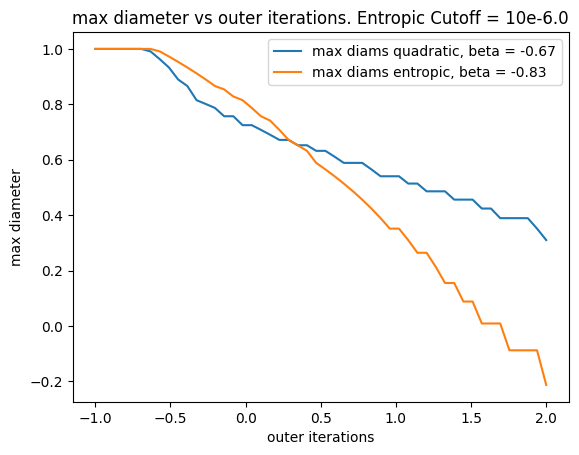

In [12]:
plt.figure()


xs_q = np.log10(np.array([distribution_outputs_quadratic[epsilon][4] for epsilon in epsilons]))
xs_e = np.log10(np.array([distribution_outputs_entropic[epsilon][4] for epsilon in epsilons]))

ys_q = np.log10(max_diams_quadratic)
ys_e = np.log10(max_diams_entropic)

var_x_q = np.mean(xs_q*xs_q) - np.mean(xs_q)**2
cov_q = np.mean(ys_q * xs) - np.mean(ys_q)*np.mean(xs_q)

var_x_e = np.mean(xs_e*xs_e) - np.mean(xs_e)**2
cov_e = np.mean(ys_e * xs) - np.mean(ys_e)*np.mean(xs_e)

beta_q = cov_q / var_x_q
beta_e = cov_e / var_x_e
plt.plot(-np.log10(epsilons), np.log10(max_diams_quadratic), label='max diams quadratic, beta = %.2f'%beta_q)
plt.plot(-np.log10(epsilons), np.log10(max_diams_entropic), label='max diams entropic, beta = %.2f'%beta_e)
plt.xlabel('outer iterations')
plt.ylabel('max diameter')
plt.title('max diameter vs outer iterations. Entropic Cutoff = 10e-%.1f'%(-np.log10(epsilon_threshold_entropic)))
plt.legend()
plt.show()